In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Damage Dataset

In [3]:
def read_damage_min_max(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_mean']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_min_max': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [4]:
def read_damage_mean(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_min_max']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_mean': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [5]:
def heat_map(_cm):
    # plot confusion matrix as heatmap
    
    labels = ['Not Damage', 'Damaged']
    
    # Set up the matplotlib figure
    plt.figure(figsize=(4, 3))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(_cm, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [6]:
#damage
damage_sixteen_url = "damage/damage_sixteen.csv"
damage_thirtytwo_url = "damage/damage_thirtytwo.csv"

df_damage_sixteen_min_max = read_damage_min_max(damage_sixteen_url)
df_damage_thirtytwo_min_max = read_damage_min_max(damage_thirtytwo_url)

df_damage_sixteen_mean = read_damage_mean(damage_sixteen_url)
df_damage_thirtytwo_mean = read_damage_mean(damage_thirtytwo_url)

In [7]:
#df_damage_sixteen_min_max

In [8]:
#df_damage_thirtytwo_min_max

In [9]:
#df_damage_sixteen_mean

In [10]:
#df_damage_thirtytwo_mean

In [11]:
#STOP

In [12]:
df = df_damage_sixteen_min_max

In [13]:
#df

In [14]:
# set up the file paths for your image data and labels
img_size = (128, 128)

data_dir = 'damage/images'

# convert the DataFrame to a dictionary with specific column names as key and value
label_dict = {k: v for k, v in zip(df['image'], df['Damage'])}

# create empty lists to store the image data and labels
images = []
labels = []

# loop through each image file in the directory
for filename in os.listdir(data_dir):
    # load the image file and convert it to a NumPy array
    image = load_img(os.path.join(data_dir, filename), target_size=img_size)
    image = img_to_array(image)
    # preprocess the image by scaling the pixel values to be between 0 and 1
    image = image.astype('float32') / 255.0
    # add the preprocessed image and its label to the lists
    images.append(image)
    labels.append(label_dict[filename])

# convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# print the shape of the data to verify that it's been loaded correctly
print('Image data shape:', images.shape) #(148, 64, 64, 3)
print('Label data shape:', labels.shape) #(148,)

Image data shape: (148, 128, 128, 3)
Label data shape: (148,)


In [15]:
#STOP

# Config

In [16]:
training_percent = 0.9

epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
#STOP

# Model

In [18]:
class Baseline():
    def __init__(self, _input_dim, metrics=METRICS):
        # Define the model architecture
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=_input_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=metrics)

        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

# Prepare dataset

In [19]:
X = images
y = labels

# If use loss function categorical_crossentropy and activation function softmax than
# def __init__(self, _input_dim, _num_classes, metrics=METRICS)
# model.add(Dense(_num_classes, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=metrics)

# Convert labels to one-hot encoding
# num_classes = 2
#y = to_categorical(y, num_classes=num_classes)

# split the data into a holdout set and the rest for K-Fold cross-validation
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=training_percent, random_state=42)

In [20]:
# create the model and iterate over each fold

input_dim = X_train.shape[1:]

#model = Baseline(input_dim, num_classes)
model = Baseline(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 64)                8128576   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,129,537
Trainable params: 8,129,537
Non-trainable params: 0
______________________________________________

Epoch 1/50
3/3 - 3s - loss: 0.7865 - tp: 21.0000 - fp: 38.0000 - tn: 17.0000 - fn: 12.0000 - accuracy: 0.4318 - precision: 0.3559 - recall: 0.6364 - auc: 0.5725 - prc: 0.6500 - val_loss: 0.5333 - val_tp: 10.0000 - val_fp: 3.0000 - val_tn: 26.0000 - val_fn: 6.0000 - val_accuracy: 0.8000 - val_precision: 0.7692 - val_recall: 0.6250 - val_auc: 0.7963 - val_prc: 0.8039 - 3s/epoch - 868ms/step
Epoch 2/50
3/3 - 0s - loss: 0.5231 - tp: 22.0000 - fp: 1.0000 - tn: 54.0000 - fn: 11.0000 - accuracy: 0.8636 - precision: 0.9565 - recall: 0.6667 - auc: 0.7804 - prc: 0.7682 - val_loss: 0.4265 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8567 - val_prc: 0.8418 - 499ms/epoch - 166ms/step
Epoch 3/50
3/3 - 1s - loss: 0.4723 - tp: 21.0000 - fp: 1.0000 - tn: 54.0000 - fn: 12.0000 - accuracy: 0.8523 - precision: 0.9545 - recall: 0.6364 - auc: 0.7934 - prc: 0.7565 - val_loss: 0.4068 - val_tp: 10.0000

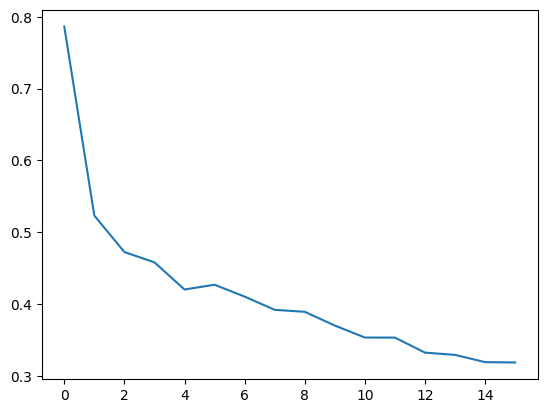

loss :  0.3668113350868225
tp :  10.0
fp :  0.0
tn :  29.0
fn :  6.0
accuracy :  0.8666666746139526
Accuracy on validation set: 0.8666666746139526
precision :  1.0
recall :  0.625
auc :  0.8318965435028076
prc :  0.8228284120559692
Epoch 1/50
3/3 - 1s - loss: 0.3193 - tp: 17.0000 - fp: 0.0000e+00 - tn: 62.0000 - fn: 10.0000 - accuracy: 0.8876 - precision: 1.0000 - recall: 0.6296 - auc: 0.8408 - prc: 0.8251 - val_loss: 0.5443 - val_tp: 14.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 8.0000 - val_accuracy: 0.7955 - val_precision: 0.9333 - val_recall: 0.6364 - val_auc: 0.7490 - val_prc: 0.8401 - 628ms/epoch - 209ms/step
Epoch 2/50
3/3 - 1s - loss: 0.3140 - tp: 17.0000 - fp: 0.0000e+00 - tn: 62.0000 - fn: 10.0000 - accuracy: 0.8876 - precision: 1.0000 - recall: 0.6296 - auc: 0.8566 - prc: 0.8322 - val_loss: 0.5632 - val_tp: 14.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 8.0000 - val_accuracy: 0.7955 - val_precision: 0.9333 - val_recall: 0.6364 - val_auc: 0.7510 - val_prc: 0.8411

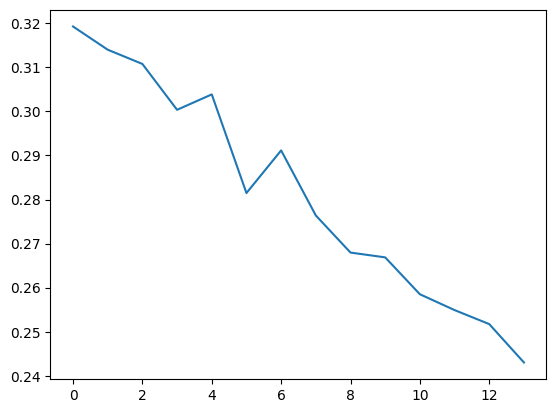

loss :  0.5347220301628113
tp :  15.0
fp :  1.0
tn :  21.0
fn :  7.0
accuracy :  0.8181818127632141
Accuracy on validation set: 0.8181818127632141
precision :  0.9375
recall :  0.6818181872367859
auc :  0.7314049601554871
prc :  0.7939673662185669
Epoch 1/50
3/3 - 1s - loss: 0.4502 - tp: 25.0000 - fp: 1.0000 - tn: 50.0000 - fn: 13.0000 - accuracy: 0.8427 - precision: 0.9615 - recall: 0.6579 - auc: 0.8083 - prc: 0.8262 - val_loss: 0.2837 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 33.0000 - val_fn: 3.0000 - val_accuracy: 0.9318 - val_precision: 1.0000 - val_recall: 0.7273 - val_auc: 0.9477 - val_prc: 0.9117 - 646ms/epoch - 215ms/step
Epoch 2/50
3/3 - 1s - loss: 0.4090 - tp: 25.0000 - fp: 1.0000 - tn: 50.0000 - fn: 13.0000 - accuracy: 0.8427 - precision: 0.9615 - recall: 0.6579 - auc: 0.8640 - prc: 0.8900 - val_loss: 0.3041 - val_tp: 7.0000 - val_fp: 0.0000e+00 - val_tn: 33.0000 - val_fn: 4.0000 - val_accuracy: 0.9091 - val_precision: 1.0000 - val_recall: 0.6364 - val_auc: 0.8636 - v

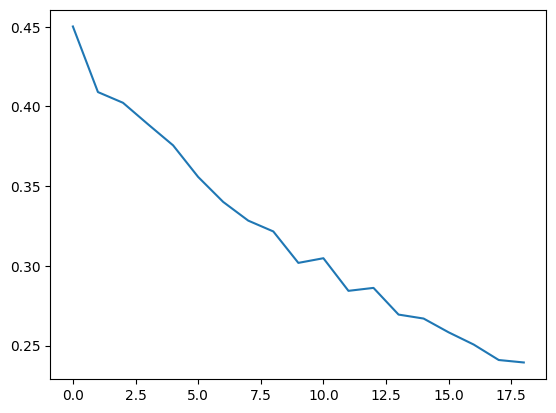

loss :  0.2508032023906708
tp :  8.0
fp :  0.0
tn :  33.0
fn :  3.0
accuracy :  0.9318181872367859
Accuracy on validation set: 0.9318181872367859
precision :  1.0
recall :  0.7272727489471436
auc :  0.9517905712127686
prc :  0.9170820713043213
results [0.2508032023906708, 8.0, 0.0, 33.0, 3.0, 0.9318181872367859, 1.0, 0.7272727489471436, 0.9517905712127686, 0.9170820713043213, 0.9318181872367859]
K-fold cross-validation accuracy: 4.5191440880298615
1/1 [==============================] - 0s 102ms/step
Accuracy on holdout set: 0.9333333333333333
Balanced Accuracy on holdout set: 0.9

Classification Report:

              precision    recall  f1-score   support

           0      0.909     1.000     0.952        10
           1      1.000     0.800     0.889         5

    accuracy                          0.933        15
   macro avg      0.955     0.900     0.921        15
weighted avg      0.939     0.933     0.931        15



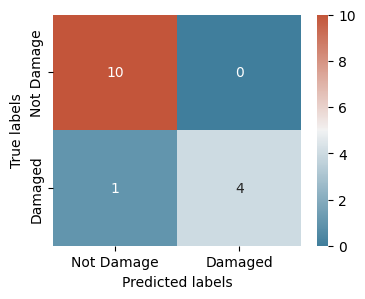

True Positive(TP)  =  4
False Positive(FP) =  0
True Negative(TN)  =  10
False Negative(FN) =  1
Accuracy of the binary classifier = 0.933


In [21]:
results = []

for train_index, val_index in kf.split(X_train):
    # split the dataset into training and validation sets for this fold
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    history = model.train(X_train_kf, y_train_kf, X_val_kf, y_val_kf, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    
    results = model.evaluate(X_val_kf, y_val_kf)
    
    for name, value in zip(model.metrics_names(), results):
        print(name, ': ', value)
        if name == 'accuracy':
            accuracy_kf = value
            results.append(accuracy_kf)
            print(f"Accuracy on validation set: {accuracy_kf}")
    
# Calculate the average accuracy score for the K-fold cross-validation
print("results",results)
print(f"K-fold cross-validation accuracy: {sum(results) / len(results)}")

# Train and evaluate the model using train-test split
#model.train(X_train, y_train, X_holdout, y_holdout, epochs, batch_size)
#y_pred = model.predict(X_holdout)
#loss function categorical_crossentropy and activation function softmax
#test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
#loss function binary_crossentropy and activation function sigmoid
#test_accuracy = accuracy_score(np.round(y_holdout), np.round(y_pred))
#print(f'Train-test split accuracy: {test_accuracy}')

y_pred_holdout = model.predict(X_holdout)
accuracy_holdout = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Accuracy on holdout set: {accuracy_holdout}")

balanced_accuracy_holdout = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Balanced Accuracy on holdout set: {balanced_accuracy_holdout}")

print("\nClassification Report:\n")
print(classification_report(np.round(y_holdout), np.round(y_pred_holdout), digits = 3))

cm = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout))
heat_map(cm)
TN, FP, FN, TP = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout)).ravel()
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP + TN) / (TP + FP + TN + FN)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

In [22]:
#STOP